<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Homework 2 - Time Series forecasting challenge</h1>
      <table align="left">
        <tr>
          <td style="text-align: left;">Bottazzi Daniele</td>
          <td style="text-align: left;"><a href="mailto:nouhaila.benhdidou@mail.polimi.it">daniele.bottazzi@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Resta Sara</td>
          <td style="text-align: left;"><a href="mailto:daniele.bottazzi@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Saldarini Gaia</td>
          <td style="text-align: left;"><a href="mailto:annalisa.imperiali@mail.polimi.it">gaia.saldarini@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 120%;">AN2DL course</b><br>
        <b>a.y. 2023-2024</b>
          <br><br>
        prof. M. Matteucci<br>
        prof. G. Boracchi<br>
      </div>
    </td>
  </tr>
</table>

# ResNet - LSTM model

 Link to dowload the `filtered_datasets` used in this Notebook: [link](https://drive.google.com/drive/folders/1FuVLBucfEEDN3pPuNTSgjwv6_3Rstn_4?usp=sharing).

In this homework you are asked to predict future samples of the input time series. The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future. The task is to develop a forecasting model that is able to predict several uncorrelated time series.

The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns

### Load and preprocess the dataset

In [ ]:
# Load dataset
unique_series = np.load('filtered_datasets/filtered_series_02.npy')
unique_valid_periods = np.load('filtered_datasets/filtered_valid_periods_02.npy')
unique_categories = np.load('filtered_datasets/filtered_categories_02.npy')

In [ ]:
# Print the shapes of the loaded datasets
print("Training data Shape:", unique_series.shape)
print("Valid periods data Shape:", unique_valid_periods.shape)
print("Categories Shape:", unique_categories.shape)

Training data Shape: (47048, 2776)
Valid periods data Shape: (47048, 2)
Categories Shape: (47048,)


In [ ]:
# Normalization
print(np.any(unique_series < 0))
print(np.any(unique_series > 1))
print(np.min(np.max(unique_series, axis=0)))

False
False
0.15527808343460037


## Process data

In [ ]:
# Remove padding from unique seqies
valid_series = np.array([row[start:end+1] for row, (start, end) in zip(unique_series, unique_valid_periods)])
valid_series.shape

(47048,)

In [ ]:
# Split into train_validation and test sets
series_train_val, series_test = train_test_split(valid_series, random_state=seed, test_size=0.1)

# Print shapes of the datasets
print(f"series_train_val shape: {series_train_val.shape}")
print(f"series_test shape: {series_test.shape}\n")

series_train_val shape: (42343,)
series_test shape: (4705,)



### Process data

In [ ]:
def replicate_array_reverse(original_array, desired_length, period=12):
    original_length = len(original_array)
    period_compliant_array = original_array[(original_length % period):]
    period_compliant_length = len(period_compliant_array)
    replication_factor = desired_length // period_compliant_length
    remainder = desired_length % period_compliant_length

    replicated_array = list(period_compliant_array[::-1]) * replication_factor + list(period_compliant_array[::-1][:remainder])

    return np.array(replicated_array[::-1])

In [ ]:
def build_sequences_univariate(series_array, window=66, stride=22, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    sequences = []
    future_sequences = []

    for (i, series) in enumerate(series_array):
        series_len = len(series)
        diff = series_len -window -telescope
        s = series

        if (diff <= 0):
          s = replicate_array_reverse(s, window + telescope)
          assert len(s) == (window + telescope)

        for idx in np.arange(len(s) - window - telescope, -1, -stride):
          # gets a slice of window + telescope of the series
          series_xy = s[idx:idx + window + telescope]

          # get the x
          series_x = series_xy[0:window]

          # add to the sequences
          sequences.append(series_x)

          # get y
          series_y = series_xy[window:window+telescope]

          # add to future sequences (already scaled)
          future_sequences.append(series_y)

    sequences = np.array(sequences)
    future_sequences = np.array(future_sequences)

    return sequences, future_sequences

In [ ]:
window = 198
stride = 11

In [ ]:
telescope = 18
direct_telescope = telescope

In [ ]:
X_train_val, y_train_val = build_sequences_univariate(series_train_val, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
print(series_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)

(42343,)
(208175, 198)
(208175, 18)


In [ ]:
X_test, y_test = build_sequences_univariate(series_test, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
print(series_test.shape)
print(X_test.shape)
print(y_test.shape)

(4705,)
(23420, 198)
(23420, 18)


In [ ]:
# Split train_validation sequences into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, shuffle=True, random_state=seed, test_size=0.2)

In [ ]:
# Expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
# Print shapes of the sequences datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}\n")

X_train shape: (166540, 198, 1), y_train shape: (166540, 18, 1)
X_val shape: (41635, 198, 1), y_val shape: (41635, 18, 1)
X_test shape: (23420, 198, 1), y_test shape: (23420, 18, 1)



### Univariate Forecating (Direct)

In [ ]:
def inspect_univariate(X, y, telescope, idx = 42):
    plt.plot(np.arange(len(X[idx])), X[idx])
    plt.scatter(np.arange(len(X[idx]), len(X[idx]) + telescope), y[idx], color='orange', s = 5)
    plt.ylim(0,1)
    plt.show()

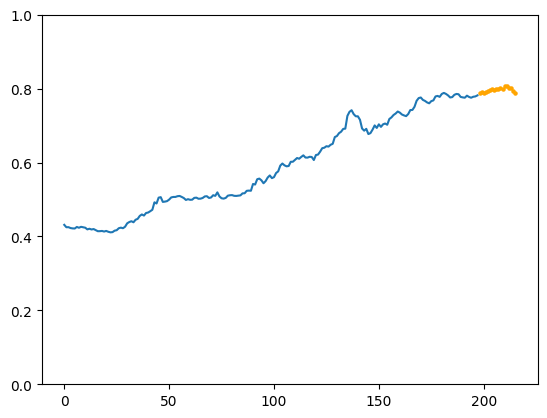

In [ ]:
inspect_univariate(X_train, y_train, direct_telescope, idx=122)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add, Dropout

def residual_block_with_dropout_and_dense_reg(x, filters, kernel_size, dropout_rate=0.2, dense_l1=1e-4, dense_l2=1e-4):
    # Shortcut
    shortcut = x

    # First convolutional layer
    x = tfkl.Conv1D(filters, kernel_size, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    # Dense layer with L1L2 regularization
    x = tf.keras.layers.Dense(filters, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=dense_l1, l2=dense_l2))(x)

    # Second convolutional layer
    x = tfkl.Conv1D(filters, kernel_size, padding='same')(x)
    x = tfkl.BatchNormalization()(x)

    # Adding Dropout after the second convolutional layer
    x = tfkl.Dropout(rate=dropout_rate)(x)

    # Skip connection
    x = tfkl.Add()([shortcut, x])
    x = tfkl.Activation('relu')(x)
    return x



def build_CONV_LSTM_model_with_resnet_and_dropout(input_shape, output_shape, dropout_rate=0.2):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= output time steps"

    # Define the input layer with the specified shape
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(input_layer)

    # Two modified residual blocks with Dropout
    for _ in range(2):
        x = residual_block_with_dropout_and_dense_reg(x, 128, 3, dropout_rate=dropout_rate)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, name='lstm'))(x)

    x = tfkl.MultiHeadAttention(num_heads=8, key_dim=1)(x, x, x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tf.keras.layers.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_with_ResNet_and_Dropout')

    # Compile the model with Mean Absolute Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

    return model

In [ ]:
input_shape  = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 200

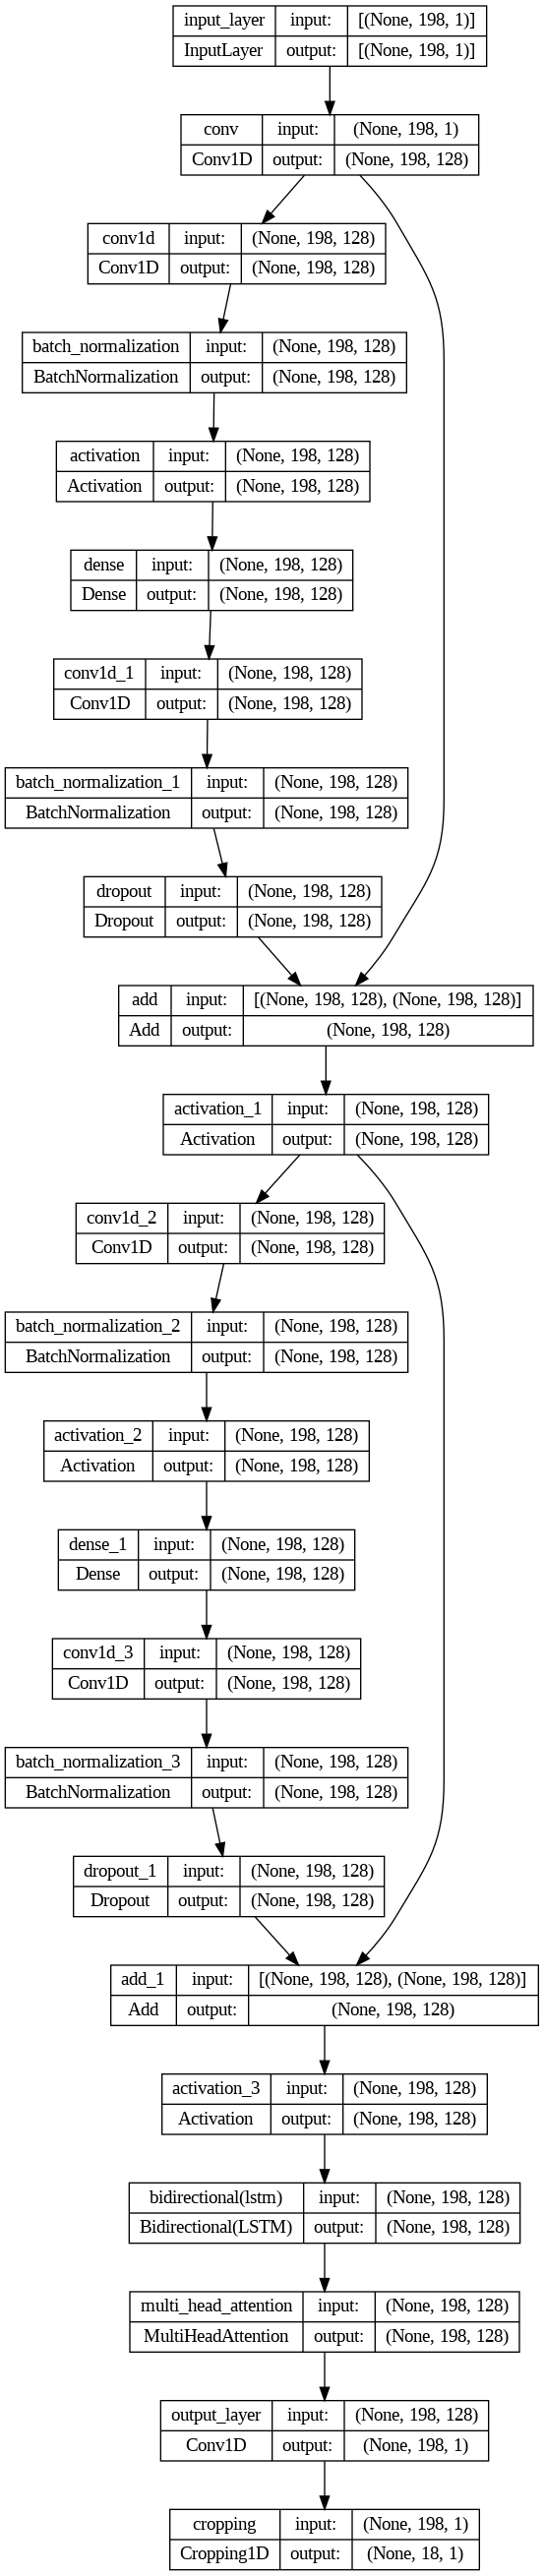

In [ ]:
model = build_CONV_LSTM_model_with_resnet_and_dropout(input_shape, output_shape, dropout_rate=0.33)
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True,min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.2, min_lr=1e-5,min_delta=1e-4)
    ]
).history

Epoch 1/200
5205/5205 [==============================] - 181s 32ms/step - loss: 0.0930 - val_loss: 0.0943 - lr: 0.0010
Epoch 2/200
5205/5205 [==============================] - 167s 32ms/step - loss: 0.0731 - val_loss: 0.0704 - lr: 0.0010
Epoch 3/200
5205/5205 [==============================] - 165s 32ms/step - loss: 0.0698 - val_loss: 0.0676 - lr: 0.0010
Epoch 4/200
5205/5205 [==============================] - 165s 32ms/step - loss: 0.0679 - val_loss: 0.0710 - lr: 0.0010
Epoch 5/200
5205/5205 [==============================] - 163s 31ms/step - loss: 0.0668 - val_loss: 0.0674 - lr: 0.0010
Epoch 6/200
5205/5205 [==============================] - 160s 31ms/step - loss: 0.0657 - val_loss: 0.0673 - lr: 0.0010
Epoch 7/200
5205/5205 [==============================] - 162s 31ms/step - loss: 0.0656 - val_loss: 0.0646 - lr: 0.0010
Epoch 8/200
5205/5205 [==============================] - 184s 35ms/step - loss: 0.0645 - val_loss: 0.0664 - lr: 0.0010
Epoch 9/200
5205/5205 [=========================

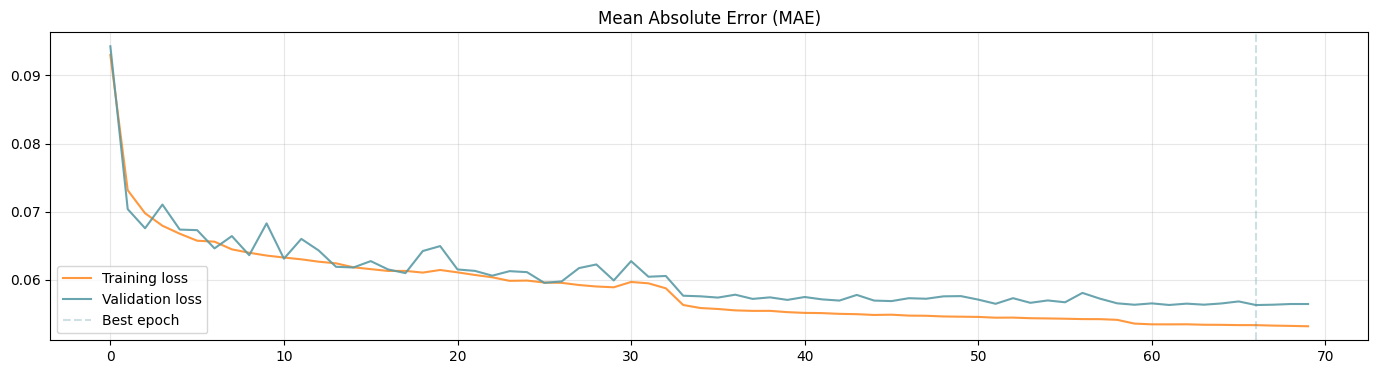

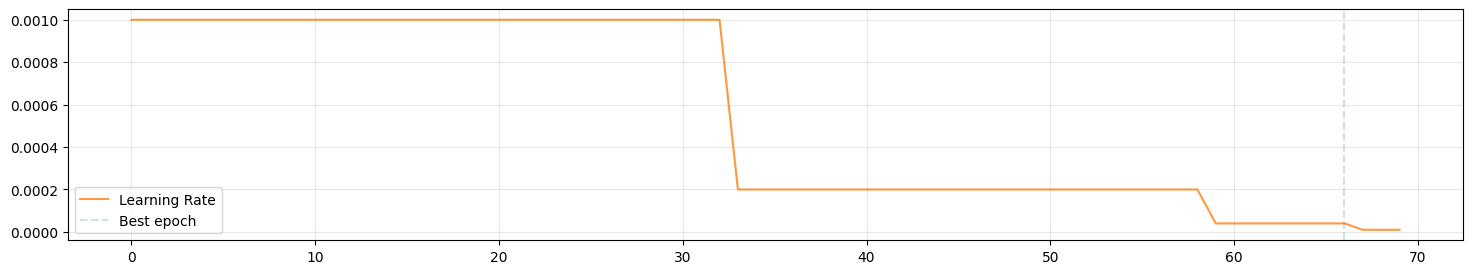

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('ResNet-BiLSTM')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

In [ ]:
predictions_9 = predictions[:, 0:9, :]
# Print the shape of the predictions
print(f"Predictions shape: {predictions_9.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test[:, 0:9, :].flatten(), predictions_9.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[:, 0:9, :].flatten(), predictions_9.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (23420, 9, 1)
Mean Squared Error: 0.005911471322178841
Mean Absolute Error: 0.04691942781209946


In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (23420, 18, 1)
Mean Squared Error: 0.008013891987502575
Mean Absolute Error: 0.056091465055942535


In [ ]:
def inspect_univariate_prediction(X, y, pred, telescope, idx = 42):
    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    plt.plot(np.arange(len(X[idx])), X[idx])
    plt.plot(np.arange(len(X[idx])-1, len(X[idx]) + telescope), y[idx], color='orange')
    plt.plot(np.arange(len(X[idx])-1, len(X[idx]) + telescope), pred[idx], color='green') # forecast
    plt.ylim(0,1)
    plt.show()

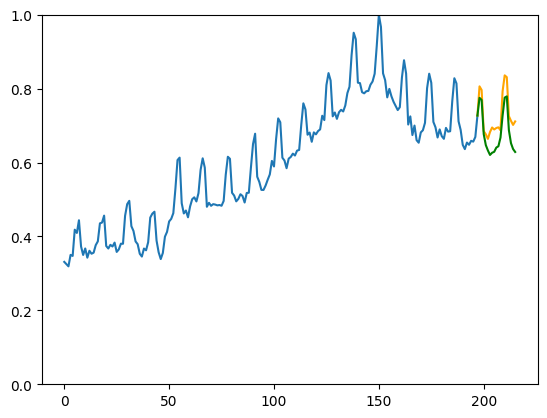

In [ ]:
inspect_univariate_prediction(X_test, y_test, predictions, direct_telescope, idx = 321)

In [ ]:
%%writefile model.py
import os
import tensorflow as tf

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):

        # Note: this is just an example.
        # Here the model.predict is called
        out = self.model.predict(X[:,-198:])  # Shape [BSx9] for Phase 1 and [BSx18] for Phase 2
        out = out.reshape(-1,18)

        return out